In [1]:
import os
import sys
import subprocess
import xml.etree.ElementTree as ET
import pip
import site
import h5py
import openvdb as vdb
import numpy as np

In [ ]:
xml_path = ""  # CHANGE THIS

# Which setup and timepoint to export (usually 0 and 0)
setup = 0
timepoint = 0

# Check if XML file exists
if not os.path.exists(xml_path):
    print(f"Error: XML file {xml_path} not found!")
    raise FileNotFoundError("Could not find XML file!")

tree = ET.parse(xml_path)
root = tree.getroot()

# Get base path
base_path_elem = root.find('.//BasePath')
base_path = base_path_elem.text if base_path_elem is not None else "."

# Get HDF5 file path
h5_elem = root.find('.//ImageLoader/hdf5')
if h5_elem is None:
    raise ValueError("No HDF5 file reference found in XML")

h5_relative = h5_elem.text
xml_dir = os.path.dirname(xml_path)
h5_path = os.path.normpath(os.path.join(xml_dir, base_path, h5_relative))

# Get first ViewSetup (assuming single channel for now)
setup = root.find('.//ViewSetup')
if setup is None:
    raise ValueError("No ViewSetup found in XML")

# Get size
size_elem = setup.find('.//size')
size = [int(x) for x in size_elem.text.split()] if size_elem is not None else None

# Get voxel size
voxel_size_elem = setup.find('.//voxelSize/size')
voxel_size = [float(x) for x in voxel_size_elem.text.split()] if voxel_size_elem is not None else None

# Get unit
unit_elem = setup.find('.//voxelSize/unit')
unit = unit_elem.text if unit_elem is not None else "unknown"

# Get setup ID
setup_id = int(setup.find('.//id').text)

# Get transform
transform_elem = root.find(f'.//ViewRegistration[@setup="{setup_id}"]//affine')
transform = None
if transform_elem is not None:
    transform = [float(x) for x in transform_elem.text.split()]

metadata = {
    'h5_path': h5_path,
    'size': size,
    'voxel_size': voxel_size,
    'unit': unit,
    'setup_id': setup_id,
    'transform': transform
}

In [ ]:
print(f"HDF5 file: {metadata['h5_path']}")
print(f"Volume size: {metadata['size']}")
print(f"Voxel size: {metadata['voxel_size']} {metadata['unit']}")

# Check if HDF5 file exists
if not os.path.exists(metadata['h5_path']):
    print(f"Error: HDF5 file {metadata['h5_path']} not found!")
    raise FileNotFoundError("No HDF5 file at this location!")

# Read HDF5 file
# BDV format uses path: t{timepoint}/s{setup}/0/cells
dataset_path = f"t{timepoint:05d}/s{setup_id:02d}/0/cells"

print(f"Reading dataset: {dataset_path}")

f = h5py.File(metadata['h5_path'], 'r')

if dataset_path not in f:
    print(f"Error: Dataset {dataset_path} not found!")
    print(f"Available datasets: {list(f.keys())}")
    raise FileNotFoundError

data = f[dataset_path][:]

In [82]:
f.keys()

<KeysViewHDF5 ['__DATA_TYPES__', 's00', 't00000', 't00001', 't00002', 't00003', 't00004', 't00005', 't00006', 't00007', 't00008', 't00009', 't00010', 't00011', 't00012', 't00013', 't00014', 't00015', 't00016', 't00017', 't00018', 't00019', 't00020', 't00021', 't00022', 't00023', 't00024', 't00025', 't00026', 't00027', 't00028', 't00029', 't00030', 't00031', 't00032', 't00033', 't00034', 't00035', 't00036', 't00037', 't00038', 't00039', 't00040', 't00041', 't00042', 't00043', 't00044', 't00045', 't00046', 't00047', 't00048', 't00049', 't00050', 't00051', 't00052', 't00053', 't00054', 't00055', 't00056', 't00057', 't00058', 't00059', 't00060', 't00061', 't00062', 't00063', 't00064', 't00065', 't00066', 't00067', 't00068', 't00069', 't00070', 't00071', 't00072', 't00073', 't00074', 't00075', 't00076', 't00077', 't00078', 't00079', 't00080', 't00081', 't00082', 't00083', 't00084', 't00085', 't00086', 't00087', 't00088', 't00089', 't00090', 't00091', 't00092', 't00093', 't00094', 't00095', 

In [68]:
timepoints = [entry for entry in list(f.keys()) if str(entry).startswith("t")]

In [ ]:
timepoints

['t00000',
 't00001',
 't00002',
 't00003',
 't00004',
 't00005',
 't00006',
 't00007',
 't00008',
 't00009',
 't00010',
 't00011',
 't00012',
 't00013',
 't00014',
 't00015',
 't00016',
 't00017',
 't00018',
 't00019',
 't00020',
 't00021',
 't00022',
 't00023',
 't00024',
 't00025',
 't00026',
 't00027',
 't00028',
 't00029']

In [69]:
import matplotlib.pyplot as plt

In [83]:
data.shape

(113, 660, 700)

[]

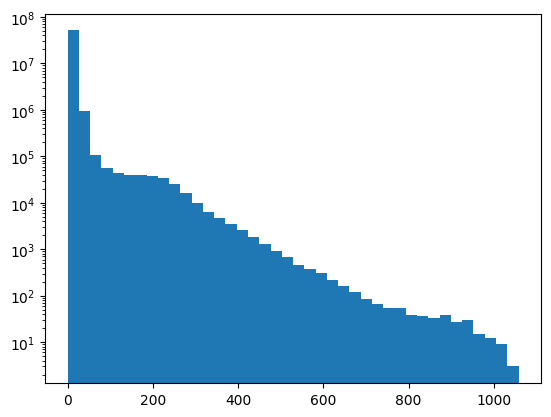

In [89]:
plt.hist(data.ravel(), bins=40)
# plt.loglog()
plt.semilogy()

In [85]:
print("median:", np.median(data))
print("mean: ", np.mean(data))

median: 5.0
mean:  6.909546661303298


In [90]:
print(f"Data shape: {data.shape}, dtype: {data.dtype}")
print(f"Value range: [{np.min(data)}, {np.max(data)}]")

Data shape: (113, 660, 700), dtype: int16
Value range: [0, 1058]


In [ ]:
metadata

In [44]:
# Create OpenVDB grid
print("Creating OpenVDB grid...")
grid = vdb.FloatGrid()
grid.name = "density"

# Set voxel size (transform) if available
if metadata['voxel_size']:
    voxel_size = metadata['voxel_size']
    # Create transform matrix for proper scaling
    transform = vdb.Transform()
    
    transform.preScale((voxel_size[2], voxel_size[1], voxel_size[0]))
    
    grid.transform = transform
    print(f"Applied voxel spacing: {voxel_size}")

Creating OpenVDB grid...
Applied voxel spacing: [1.3934000214583604, 1.3934000214583604, 1.3934]


In [38]:
p = data.transpose(2, 1, 0)

In [39]:
p.shape

(151, 101, 29)

In [45]:
data_norm = data.astype(np.float32)
data_norm = data_norm/data.max()

In [ ]:
# Fill the grid
tol = 0.1 * np.mean(data_norm)
grid.clear()
grid.copyFromArray(data_norm, tolerance=tol)
grid.saveFloatAsHalf = True
grid.prune()

In [47]:
print(f"Active voxel count: {grid.activeVoxelCount()}")
print(f"Active voxel BB:    {grid.evalActiveVoxelBoundingBox()}")
print(f"Active voxel dims:  {grid.evalActiveVoxelDim()}")
print(f"Min/Max values:     {grid.evalMinMax()}")
print(f"Leaf count:         {grid.leafCount()}")

Active voxel count: 26201009
Active voxel BB:    ((0, 0, 0), (288, 263, 345))
Active voxel dims:  (289, 264, 346)
Min/Max values:     (0.005265137180685997, 1.0)
Leaf count:         16168


In [102]:
import matplotlib.pyplot as plt

In [42]:
data.shape

(289, 264, 346)

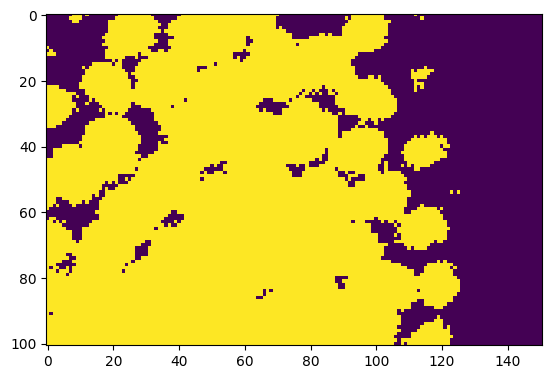

In [144]:
plt.imshow(data[10] > 200)

In [ ]:
# Generate output path (same directory as XML)
output_path = os.path.splitext(xml_path)[0] + f"_tol{tol}" + ".vdb"

# Write VDB file
print(f"Writing OpenVDB file: {output_path}")
vdb.write(output_path, grids=[grid])
print("Conversion complete!")
print(f"Output file: {output_path}")